<a href="https://colab.research.google.com/github/TayJen/hackathon_algu2022/blob/master/H_ALGU_2022_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/Shareddrives/data_drive/H_Vladivostok2022
!pwd

/content/drive/Shareddrives/data_drive/H_Vladivostok2022
/content/drive/Shareddrives/data_drive/H_Vladivostok2022


## Загрузим нужные библиотеки

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np

%matplotlib inline
mpl.rcParams['figure.facecolor'] = 'white'
np.random.seed(59)

### Считаем тренировочный набор

In [4]:
df_issues_train = pd.read_csv("./data/train/train_issues.csv")
df_emp = pd.read_csv("./data/employees.csv")

## Рассмотрим датасет поближе

In [5]:
df_issues_train.head(3)

,id,created,key,summary,project_id,assignee_id,creator_id,overall_worklogs
0,819952,2019-10-01 05:57:18.000,SM-10678,"UI тесты по заказу ""Добро КейДжи""",5,93,93,1800
1,819949,2019-10-01 05:59:45.000,SM-10679,"UI тесты раздела ""Профиль""",5,93,93,7200
2,819947,2019-10-01 06:00:38.000,SM-10680,"UI тесты раздела ""Личный счет""",5,93,93,14400


In [6]:
df_issues_train.shape

(9589, 8)

In [7]:
df_issues_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9589 entries, 0 to 9588
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                9589 non-null   int64 
 1   created           9589 non-null   object
 2   key               9589 non-null   object
 3   summary           9589 non-null   object
 4   project_id        9589 non-null   int64 
 5   assignee_id       9589 non-null   int64 
 6   creator_id        9589 non-null   int64 
 7   overall_worklogs  9589 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 599.4+ KB


### Преобразование столбцов

Сделаем два столбца - день и месяц создания задачи

In [8]:
df_issues_train["month"] = df_issues_train.created.map(lambda x : int(x.split("-")[1]))
df_issues_train["day"] = df_issues_train.created.map(lambda x : int(x.split("-")[2].split()[0]))

Удалим не нужную информацию о работниках

In [9]:
df_emp = df_emp.drop(["active", "full_name", "salary_calculation_type", "passport"], axis = 1)

Обьединим два набора данных по id исполнителя

In [10]:
df_train = pd.merge(df_issues_train, df_emp, left_on="assignee_id", right_on="id", how='inner')
df_train = df_train.fillna(0)
df_train.shape

(9589, 19)

 Создадим список всех не числовых лейблов и взглянем на них

In [11]:
mass_object = df_train.dtypes[df_train.dtypes == "object"].index.values
df_train[mass_object].head(3)

,created,key,summary,position,hiring_type,payment_type,english_level
0,2019-10-01 05:57:18.000,SM-10678,"UI тесты по заказу ""Добро КейДжи""",Разработчик мобильных приложений,staff,fixed,0
1,2019-10-01 05:59:45.000,SM-10679,"UI тесты раздела ""Профиль""",Разработчик мобильных приложений,staff,fixed,0
2,2019-10-01 06:00:38.000,SM-10680,"UI тесты раздела ""Личный счет""",Разработчик мобильных приложений,staff,fixed,0


Взглянем на них поближе

In [12]:
df_train.hiring_type.value_counts()

staff        7005
0            1959
non_staff     625
Name: hiring_type, dtype: int64

In [13]:
df_train.payment_type.value_counts()

fixed     5765
0         2060
hourly    1764
Name: payment_type, dtype: int64

In [14]:
df_train.english_level.value_counts()

0     9055
B1     358
C1     176
Name: english_level, dtype: int64

Сменим им тип данных

In [15]:
cat_cols = ['payment_type', 
            'hiring_type',
            'english_level']

for cat in cat_cols:
    df_train[cat] = pd.Categorical(df_train[cat])
    df_train[cat].astype('category').cat.codes
    df_train[cat] = df_train[cat].cat.codes

Распределение различных значений

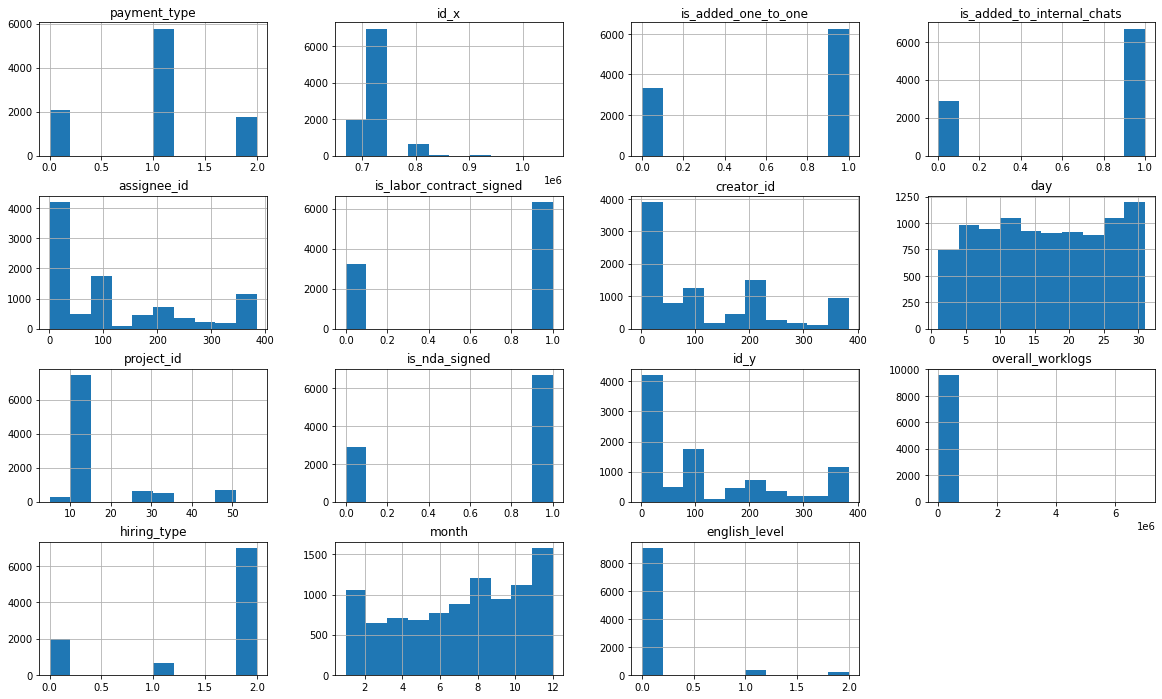

In [16]:
mass_object = df_train.dtypes[df_train.dtypes == "object"].index.values
features = list(set(df_train.columns.to_list()) - set(mass_object))

# with plt.style.context('seaborn-white'):
_ = df_train[features].hist(figsize=(20, 12))

Рассмотрим корреляцию всех признаков

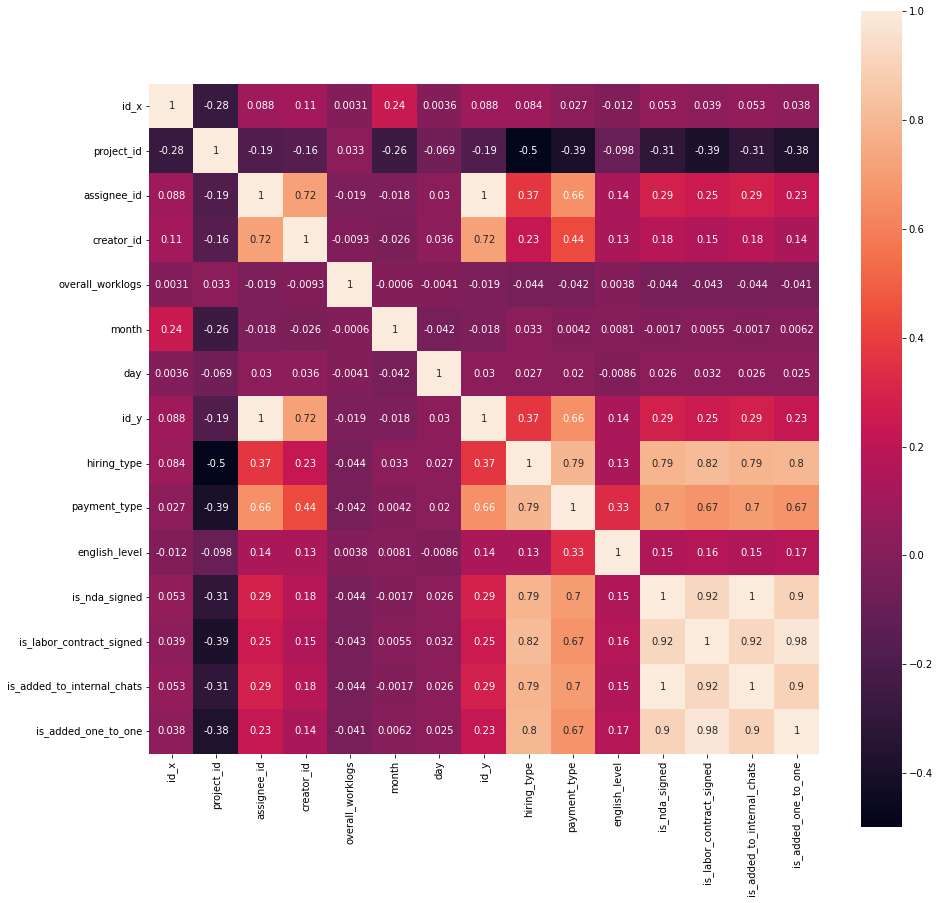

In [17]:
corr = df_train.corr()
# with plt.style.context('seaborn-white'):
plt.rcParams['figure.figsize'] = (15,15)
g = sns.heatmap(corr, square = True, annot=True)
plt.show()

## Выделим выборки

Удалим все лишние столбцы из выборки

In [18]:
mass_object = df_train.dtypes[df_train.dtypes == "object"].index.values
stuff = ["id_x", "id_y", "overall_worklogs"]

mass_object = np.append(mass_object, stuff)

X = df_train.drop(mass_object, axis=1)
y = df_train[["overall_worklogs"]] // 900
X.head(3)

,project_id,assignee_id,creator_id,month,day,hiring_type,payment_type,english_level,is_nda_signed,is_labor_contract_signed,is_added_to_internal_chats,is_added_one_to_one
0,5,93,93,10,1,2,1,0,1,1,1,1
1,5,93,93,10,1,2,1,0,1,1,1,1
2,5,93,93,10,1,2,1,0,1,1,1,1


In [19]:
y

,overall_worklogs
0,2
1,8
2,16
3,1
4,1
...,...
9584,20
9585,18
9586,4
9587,7


In [20]:
X.shape

(9589, 12)

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=59)

## Обучение модели

In [22]:
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor(random_state=59)

In [23]:
clf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(random_state=59)

## Оценка точности

In [24]:
pred = np.rint(clf.predict(X_val)).astype('int')

In [25]:
from sklearn.metrics import r2_score

score = r2_score(y_val, pred)
score

-0.05790791874846968

### XGBoost

In [26]:
from xgboost import XGBRegressor

model = XGBRegressor(random_state=59)
model.fit(X_train, y_train)

pred = np.rint(clf.predict(X_val)).astype('int')
score = r2_score(y_val, pred)
score

[16:27:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


-0.05790791874846968

## Сабмит на сайт

In [27]:
df_issues_test = pd.read_csv("./data/test/test_issues.csv")

In [28]:
df_issues_test["month"] = df_issues_test.created.map(lambda x : int(x.split("-")[1]))
df_issues_test["day"] = df_issues_test.created.map(lambda x : int(x.split("-")[2].split()[0]))

In [29]:
df_issues_test.head()

,id,created,key,summary,project_id,assignee_id,creator_id,month,day
0,675975,2020-01-15 09:52:57.000,SM-11140,Выгрузить все mp3 файлы звонков на диск,5,112,112,1,15
1,675972,2020-01-15 09:54:35.000,SM-11141,Удалить файлы mp3 звонков с сервера до 01.01.2019,5,112,112,1,15
2,675965,2020-01-16 04:46:17.000,SM-11144,Удалить окно выбора тарифов и перенести функци...,5,94,54,1,16
3,675961,2020-01-16 11:12:18.000,SM-11146,При авторизации пользователь/водитель не видит...,5,94,94,1,16
4,675955,2020-01-17 05:19:39.000,SM-11150,Основные проблемы по корп. отделу (по состояни...,5,1,54,1,17


In [30]:
df_test = pd.merge(df_issues_test, df_emp, left_on="assignee_id", right_on="id", how='inner')
df_test = df_test.fillna(0)
df_test.head()

,id_x,created,key,summary,project_id,assignee_id,creator_id,month,day,id_y,position,hiring_type,payment_type,english_level,is_nda_signed,is_labor_contract_signed,is_added_to_internal_chats,is_added_one_to_one
0,675975,2020-01-15 09:52:57.000,SM-11140,Выгрузить все mp3 файлы звонков на диск,5,112,112,1,15,112,DevOps инженер,staff,fixed,0,0,0,0,0
1,675972,2020-01-15 09:54:35.000,SM-11141,Удалить файлы mp3 звонков с сервера до 01.01.2019,5,112,112,1,15,112,DevOps инженер,staff,fixed,0,0,0,0,0
2,675917,2020-02-01 02:24:11.000,SM-11174,Водители не могут нажать на кнопку «на месте» ...,5,112,1,2,1,112,DevOps инженер,staff,fixed,0,0,0,0,0
3,675915,2020-02-01 02:27:30.000,SM-11175,Категория тарифа в карточке тарифа не всегда а...,5,112,1,2,1,112,DevOps инженер,staff,fixed,0,0,0,0,0
4,675912,2020-02-03 05:05:30.000,SM-11176,Добавить ip адрес с список разрешённых к подкл...,5,112,1,2,3,112,DevOps инженер,staff,fixed,0,0,0,0,0


In [31]:
cat_cols = ['payment_type', 
            'hiring_type',
            'english_level']

for cat in cat_cols:
    df_test[cat] = pd.Categorical(df_test[cat])
    df_test[cat].astype('category').cat.codes
    df_test[cat] = df_test[cat].cat.codes

In [32]:
mass_object = df_test.dtypes[df_test.dtypes == "object"].index.values
stuff = ["id_x", "id_y"]

mass_object = np.append(mass_object, stuff)

X_test = df_test.drop(mass_object, axis=1)
X_test.head(3)

,project_id,assignee_id,creator_id,month,day,hiring_type,payment_type,english_level,is_nda_signed,is_labor_contract_signed,is_added_to_internal_chats,is_added_one_to_one
0,5,112,112,1,15,2,1,0,0,0,0,0
1,5,112,112,1,15,2,1,0,0,0,0,0
2,5,112,1,2,1,2,1,0,0,0,0,0


In [33]:
prediction_site = np.rint(model.predict(X_test)).astype('int32')
prediction_site

array([ 31,  31, -25, ...,  38,  38,  18], dtype=int32)

### Взглянем на пример сабмишна и сделаем свой для сайта

In [34]:
df_sample = pd.read_csv('./data/sample_solution.csv')
df_sample.head()

,id,overall_worklogs
0,675975,0
1,675972,0
2,675965,0
3,675961,0
4,675955,0


In [35]:
len(prediction_site), len(df_sample)

(1070, 1070)

In [36]:
df_sample.overall_worklogs = prediction_site * 900
df_sample.head()

,id,overall_worklogs
0,675975,27900
1,675972,27900
2,675965,-22500
3,675961,-22500
4,675955,-10800


In [37]:
# !mkdir solutions

In [38]:
df_sample.to_csv('./solutions/baseline_15mins_xgb.csv', index=False)

### Проверка предсказания

In [39]:
df_solution = pd.read_csv('./solutions/baseline_15mins_xgb.csv')
df_solution.head()

,id,overall_worklogs
0,675975,27900
1,675972,27900
2,675965,-22500
3,675961,-22500
4,675955,-10800


In [43]:
median = int(df_train.overall_worklogs.median())
median

7200

In [44]:
df_dumb_solution = pd.read_csv('./data/sample_solution.csv')
df_dumb_solution.overall_worklogs = median
df_dumb_solution.head()

,id,overall_worklogs
0,675975,7200
1,675972,7200
2,675965,7200
3,675961,7200
4,675955,7200


In [45]:
df_dumb_solution.to_csv('./solutions/dumb_solution.csv', index=False)

In [ ]:
df_sample